# A comment on Kirill Kalinin's piece in Meduza

https://meduza.io/feature/2018/05/07/issledovatel-iz-stenforda-schitaet-chto-falsifikatsiy-na-vyborah-prezidenta-rossii-bylo-ochen-malo-kak-on-eto-vychislil

In [1]:
# Load libraries and set up notebook

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
from zipfile import ZipFile
import pickle
import time

import matplotlib as mpl
mpl.rcParams.update({'nbagg.transparent': False, 'figure.facecolor': 'white'})

In [2]:
# Load data for a given year

def loaddata(year):
    zip_file = ZipFile('electionsData.zip')
    
    table = pd.read_csv(zip_file.open('{}.txt'.format(year)), sep='\t')
        
    colFilter = ['ПУТИН', 'Путин', 'Единая Россия', 'ЕДИНАЯ РОССИЯ', 'Медведев']
    col = [col for col in table.columns if any([f in col for f in colFilter])]
    leader = np.squeeze(table[col].values)
    
    colFilter = ['Число избирателей, включенных', 'Число избирателей, внесенных']
    col = [col for col in table.columns if any([f in col for f in colFilter])]
    voters = np.squeeze(table[col].values)
    
    colFilter = ['бюллетеней, выданных']                # should select 3 columns
    col = [col for col in table.columns if any([f in col for f in colFilter])]
    given = np.sum(table[col].values, axis=1)

    colFilter = ['действительных', 'недействительных']  # should select 2 columns
    excludeFilter = ['отметок']  # excludes one additional column in the 2000 data
    col = [col for col in table.columns if any([f in col for f in colFilter]) and 
                                           all([f not in col for f in excludeFilter])]
    received = np.sum(table[col].values, axis=1)
    
    regions = table['region'].values
    tiks = table['tik'].values
    
    return (voters, given, received, leader, regions, tiks)

## Mebane's model fits

In [246]:
# Load Mebane's fits
betas = pd.read_csv('mebane-kalinin.txt', sep='\t', index_col=0)
display(betas)

mebanefits = {}
for year in [2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016]:
    mebanefits[year] = {}
    for param in list(betas.index):
        mebanefits[year][param] = betas.loc[param, str(year)]
mebanefits[2018] = None

,2000,2003,2004,2007,2008,2011,2012,2016
f_i,0.033104,0.157273,0.049295,0.039895,0.013020,0.120942,0.084398,0.221630
f_e,0.000032,0.003252,0.000087,0.000160,0.000002,0.003226,0.002042,0.021920
alpha,3.334111,3.334111,1.667556,1.667556,1.667556,1.755556,3.411111,1.667556
tau,0.711283,0.583640,0.692308,0.671109,0.755319,0.605785,0.652860,0.478814
nu,0.536609,0.357955,0.715403,0.660551,0.701884,0.481482,0.651276,0.491272
sigma_nu,0.157677,0.118856,0.132726,0.137326,0.120471,0.154413,0.129154,0.129822
sigma_tau,0.110259,0.133212,0.134965,0.135348,0.170760,0.134852,0.110636,0.125172
theta,0.709232,0.265968,0.443274,0.531926,0.531926,0.354621,0.354634,0.265968


In [106]:
# Turnouts

years = [2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016]
for i,y in enumerate(years):
    voters, given, received, leader, regions, tiks = loaddata(y)
    print('{}: {:2.0f}% {:2.0f}% {:2.0f}%'.format(y, 
                                   100 * np.sum(given)/np.sum(voters), 
                                   100 * np.mean(given[voters>0]/voters[voters>0]), 
                                   100 * beta[3,i]))

2000: 69% 74% 71%
2003: 56% 63% 58%
2004: 64% 72% 69%
2007: 64% 71% 67%
2008: 70% 76% 76%
2011: 60% 66% 61%
2012: 65% 70% 65%
2016: 48% 55% 48%


In [256]:
# q = chi2.ppf(q=.75, df=2)
# e = mpl.patches.Ellipse((100*beta[3,i], 100*beta[4,i]), 
#                          2*np.sqrt(q)*beta[6,i]*100, 2*np.sqrt(q)*beta[5,i]*100, 
#                          edgecolor='w', facecolor='none', linewidth=1)
# plt.gca().add_patch(e)

In [253]:
# Get Klimek PNAS fits

years = [2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016, 2018]
klimekfits = dict(zip(years, [None for y in years]))
klimek_alphas = [2.5, 2.2, 2.3, 1.5]
klimek_fis = [0.31, 0.636, 0.64, 0.39]
klimek_fes = [0.009, 0.038, 0.033, 0.021]

x = np.arange(0, 1, .001)
for i, year in enumerate([2003, 2007, 2011, 2012]):
    voters, given, received, leader, regions, tiks = loaddata(year)
    t = given[received>0]/voters[received>0]
    v = leader[received>0]/received[received>0]
    klimekfits[year] = {}
    klimekfits[year]['tau'] = x[np.where((x[:-1]>.3) & (np.diff(gaussian_kde(t).evaluate(x))<0))[0][0]]
    klimekfits[year]['nu']  = x[np.where((x[:-1]>.3) & (np.diff(gaussian_kde(v).evaluate(x))<0))[0][0]]
    t = t - klimekfits[year]['tau']
    v = v - klimekfits[year]['nu']
    klimekfits[year]['sigma_tau'] = np.sqrt(np.mean(t[(t<0) & (v<0)]**2))
    klimekfits[year]['sigma_nu']  = np.sqrt(np.mean(v[v<0]**2)) # Paper says sqrt(2) here, but I think it's a typo
    klimekfits[year]['theta']     = np.sqrt(np.sqrt(np.mean(v[v>0]**2))) # yes, double sqrt! See Klimek SI
    klimekfits[year]['f_i']   = klimek_fis[i]
    klimekfits[year]['f_e']   = klimek_fes[i]
    klimekfits[year]['alpha'] = klimek_alphas[i]

In [254]:
# Simulate Klimek's model

def simulateklimek(voters, params):
    n = np.size(voters)
    simulated_turnout = np.random.normal(params['tau'], params['sigma_tau'], (2*n,))
    simulated_result  = np.random.normal(params['nu'],  params['sigma_nu'],  (2*n,))
    simulated_turnout = simulated_turnout[simulated_turnout<=1][:n]
    simulated_result  = simulated_result[simulated_result  <=1][:n]
    f = np.random.uniform(size=(n,))
    xi = np.zeros_like(f)
    fraud_ind = f <= params['f_i']
    xi[fraud_ind] = np.abs(np.random.normal(0, params['theta'], size=(np.sum(fraud_ind),)))
    fraud_ind = (f > params['f_i']) & (f <= params['f_i']+params['f_e'])
    xi[fraud_ind] = 1 - np.abs(np.random.normal(0, 0.075, size=(np.sum(fraud_ind),)))
    leader = voters * (simulated_turnout*simulated_result + 
                                xi * (1-simulated_turnout) + 
                                xi**params['alpha'] * (1-simulated_result) * simulated_turnout)
    given = voters - voters * (1 - xi) * (1 - simulated_turnout)
    return (given/voters, leader/given)

<IPython.core.display.Javascript object>


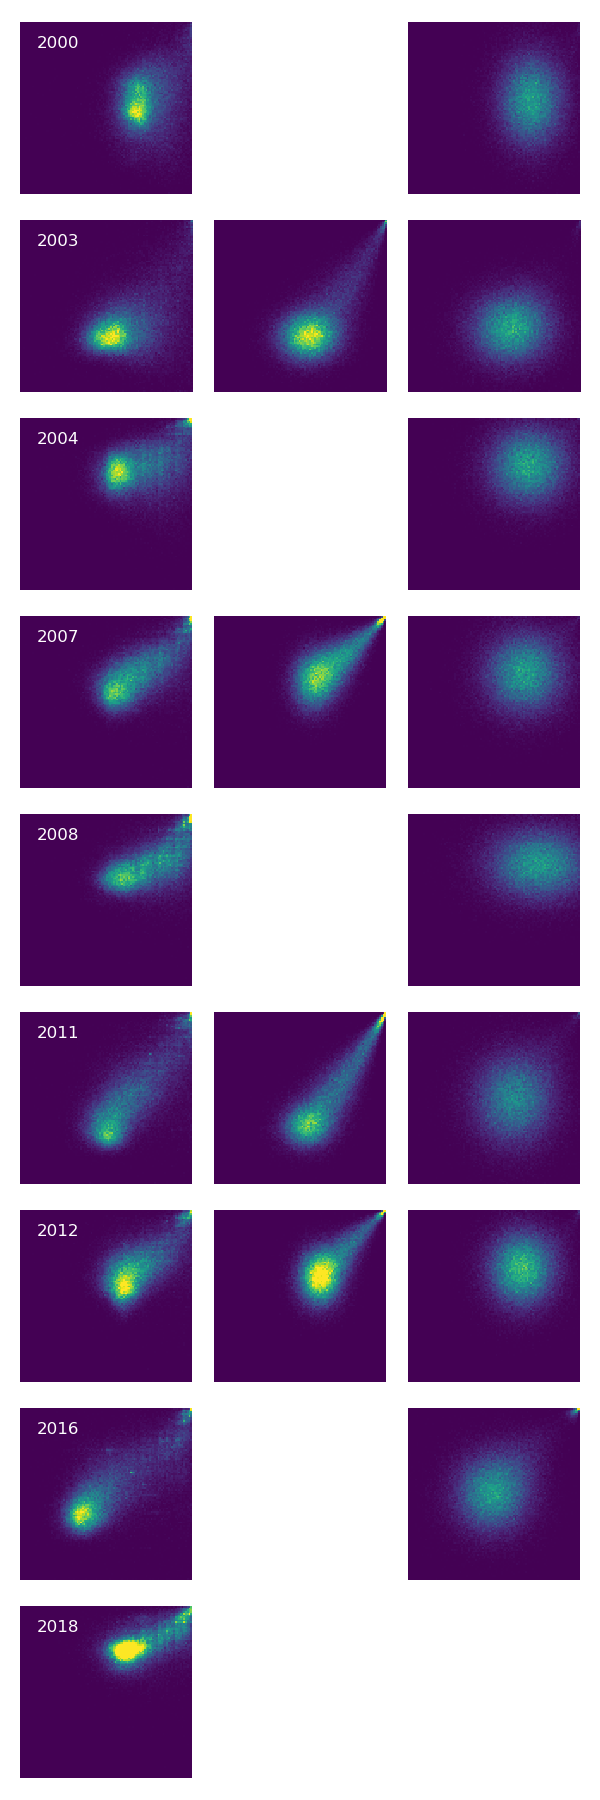

In [255]:
binwidth = 1
edges = np.arange(-binwidth/2, 100+binwidth/2, binwidth)
centers = np.arange(0,100,binwidth)

plt.figure(figsize=(2*3,2))
for i,year in enumerate(years):
    voters, given, received, leader, regions, tiks = loaddata(year)

    ifInside = ['Зарубеж' not in s and 'за пределами' not in s for s in regions]
    ind = (received > 0) & (given < voters) & np.array(ifInside)
    h = np.histogram2d(100 * given[ind]/voters[ind], 100 * leader[ind]/received[ind], bins=edges)[0]
       
    plt.subplot(np.size(years), 3, 1 + i*3)
    plt.imshow(h.T, vmin=0, vmax=150, origin='lower', extent=[0,100,0,100], 
               cmap=plt.get_cmap('viridis'), interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.text(10, 85, year, color='w')
    
    if klimekfits[year] is not None:
        t,v = simulateklimek(voters[received>0], klimekfits[year])
        h = np.histogram2d(100 * t, 100 * v, bins=edges)[0]

        plt.subplot(np.size(years), 3, 2 + i*3)
        plt.imshow(h.T, vmin=0, vmax=150, origin='lower', extent=[0,100,0,100], 
               cmap=plt.get_cmap('viridis'), interpolation='none')
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        
    if mebanefits[year] is not None:
        t,v = simulateklimek(voters[received>0], mebanefits[year])
        h = np.histogram2d(100 * t, 100 * v, bins=edges)[0]

        plt.subplot(np.size(years), 3, 3 + i*3)
        plt.imshow(h.T, vmin=0, vmax=150, origin='lower', extent=[0,100,0,100], 
               cmap=plt.get_cmap('viridis'), interpolation='none')
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
    
plt.tight_layout()

# Specific region

<IPython.core.display.Javascript object>


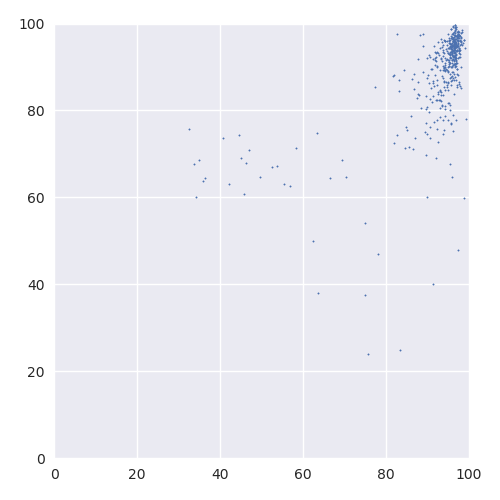

In [133]:
year = 2018
binwidth = 1

edges = np.arange(-binwidth/2, 100+binwidth/2, binwidth)
centers = np.arange(0,100,binwidth)

plt.figure(figsize=(5,5))

voters, given, received, leader, regions, tiks = loaddata(year)

reg = ['Чеченск' in s or 'аБашкортостан' in s for s in regions]
ind = (received > 0) & (given < voters) & np.array(reg)
h = np.histogram2d(100 * given[ind]/voters[ind], 100 * leader[ind]/received[ind], bins=edges)[0]
        
# plt.imshow(h.T, vmin=0, vmax=25, origin='lower', extent=[0,100,0,100], 
#                cmap=plt.get_cmap('viridis'), interpolation='none')
plt.scatter(100 * given[ind]/voters[ind], 100 * leader[ind]/received[ind], s=1)
plt.xlim([0,100])
plt.ylim([0,100])
# plt.xticks([])
# plt.yticks([])
# plt.axis('off')
plt.tight_layout()

In [137]:
np.sum(leader[ind]) - np.sum(voters[ind]) * 0.5 * 0.65

np.sum(received[ind]) - np.sum(voters[ind]) * 0.5

285371.5

# MC with round percentages

..................................................................................... 1m 34s
........................................................................................ 1m 39s
...................................................................................... 1m 41s
...................................................................................... 1m 42s
....................................................................................... 1m 50s
....................................................................................... 1m 34s
........................................................................................ 1m 35s
........................................................................................... 1m 34s
............................................................................................ 1m 37s


<IPython.core.display.Javascript object>


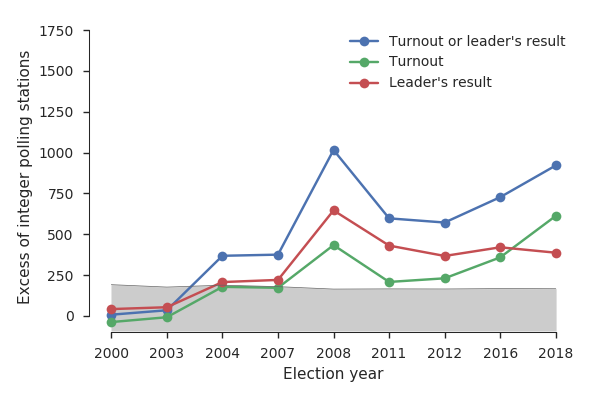

In [144]:
# Monte Carlo simulations

def anomaly(voters, given, received, leader, nrep=1000, prctl = 99.9, seed=42,
            resolution = 1, binw = 1, weights=np.ones_like(voters)):
    
    # inclusion criteria that we used in the AOAS paper
    ind = (received > 0) & (voters >= 100)
    indd = (given[ind]/voters[ind] <= .99) & (leader[ind]/received[ind] <= .99)
    ind[np.where(ind)[0][~indd]] = False    
    
    p1 = 100 * leader[ind]/received[ind]
    p2 = 100 * given[ind]/voters[ind]
    
    # first dimension:  overall / only result / only turnout
    # second dimension: number of stations, voters, given ballots, leader's ballots
    integer = np.zeros((3,4)) 
    for i,weights in enumerate([np.ones_like(voters), voters, given, leader]):
        w = weights[ind]
        integer[0,i] = np.sum(w[(np.abs(p1 - np.round(p1/resolution)*resolution) <= binw/2) | 
                                           (np.abs(p2 - np.round(p2/resolution)*resolution) <= binw/2)])
        integer[1,i] = np.sum(w[np.abs(p1 - np.round(p1/resolution)*resolution) <= binw/2])
        integer[2,i] = np.sum(w[np.abs(p2 - np.round(p2/resolution)*resolution) <= binw/2])

    t = time.time()    
    leader_binom = np.zeros((nrep, np.sum(ind)))
    given_binom  = np.zeros((nrep, np.sum(ind)))
    np.random.seed(seed)
    for n in range(np.sum(ind)):
        if n%1000 == 0:
            print('.', end='')
        leader_binom[:,n] = np.random.binomial(n=received[ind][n], 
                                               p=leader[ind][n]/received[ind][n], 
                                               size=nrep)
        given_binom[:,n]  = np.random.binomial(n=voters[ind][n],   
                                               p=given[ind][n] /voters[ind][n],   
                                               size=nrep)
    t = time.time() - t
    m,s = divmod(t, 60)
    print('{:2.0f}m {:2.0f}s'.format(m,s))
    
    p1 = 100 * leader_binom/received[ind]
    p2 = 100 * given_binom/voters[ind]    
    integer_mc = np.zeros((3,4,nrep)) 
    for i,weights in enumerate([np.ones_like(voters), voters, given, leader]):
        w = weights[ind]
        integer_mc[0,i,:] = np.sum(w * ((np.abs(p1 - np.round(p1/resolution)*resolution) <= binw/2) | 
                                        (np.abs(p2 - np.round(p2/resolution)*resolution) <= binw/2)).astype(int), axis=1)
        integer_mc[1,i,:] = np.sum(w * (np.abs(p1 - np.round(p1/resolution)*resolution) <= binw/2).astype(int), axis=1)
        integer_mc[2,i,:] = np.sum(w * (np.abs(p2 - np.round(p2/resolution)*resolution) <= binw/2).astype(int), axis=1)
        
    d = integer - np.mean(integer_mc, axis=2) 
    s = np.std(integer_mc, axis=2)
    q = np.percentile(integer_mc, prctl, axis=2) - np.mean(integer_mc, axis=2)
    return (d,s,q)  # anomaly, MC std, MC percentile

years = np.array([2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016, 2018])
anomalies = np.zeros((years.size, 3, 4))
stds  = np.zeros((years.size, 3, 4))
prctls = np.zeros((years.size, 3, 4))

for i,y in enumerate(years):
    voters, given, received, leader, regions, tiks = loaddata(y)
    a = anomaly(voters, given, received, leader, resolution=5)
    anomalies[i,:,:] = a[0]
    stds[i,:,:]      = a[1]
    prctls[i,:,:]    = a[2]
    
sns.set_style('ticks', {'axes.linewidth': .75, "xtick.major.size":4, "ytick.major.size":4})
plt.figure(figsize=(6,4))
plt.plot(anomalies[:,0,0], '-o')
plt.plot(anomalies[:,2,0], '-o')
plt.plot(anomalies[:,1,0], '-o')
plt.plot(prctls[:,0,0], '-', color=[.4,.4,.4], linewidth=.5)
plt.fill_between(np.arange(len(years)), plt.ylim()[0], prctls[:,0,0], color=[.8,.8,.8])
plt.legend(("Turnout or leader's result", "Turnout", "Leader's result"))
plt.ylabel('Excess of integer polling stations')
plt.xlabel('Election year')
plt.ylim([-100, 1800])
plt.xticks(np.arange(years.size), years)
sns.despine(trim=True)
plt.tight_layout()

..................................................................................... 1m 28s
........................................................................................ 1m 42s
...................................................................................... 1m 42s
...................................................................................... 1m 40s
....................................................................................... 1m 45s
....................................................................................... 1m 34s
........................................................................................ 1m 36s
........................................................................................... 1m 40s
............................................................................................ 1m 37s


<IPython.core.display.Javascript object>


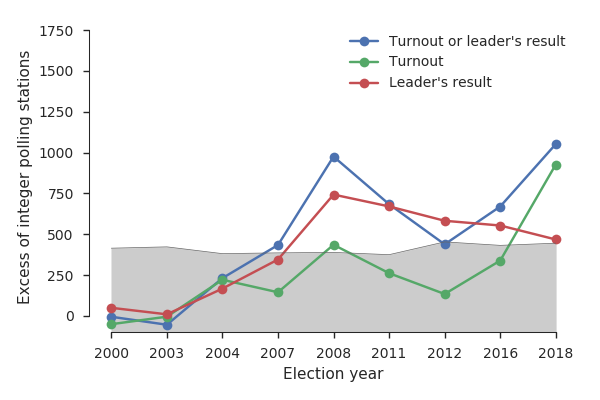

In [145]:
# Monte Carlo simulations

def anomaly(voters, given, received, leader, nrep=1000, prctl = 99.9, seed=42,
            resolution = 1, binw = 1, weights=np.ones_like(voters)):
    
    # inclusion criteria that we used in the AOAS paper
    ind = (received > 0) & (voters >= 100)
    indd = (given[ind]/voters[ind] <= .99) & (leader[ind]/received[ind] <= .99)
    ind[np.where(ind)[0][~indd]] = False    
    
    p1 = 100 * leader[ind]/received[ind]
    p2 = 100 * given[ind]/voters[ind]
    
    # first dimension:  overall / only result / only turnout
    # second dimension: number of stations, voters, given ballots, leader's ballots
    integer = np.zeros((3,4)) 
    for i,weights in enumerate([np.ones_like(voters), voters, given, leader]):
        w = weights[ind]
        integer[0,i] = np.sum(w[(np.abs(p1 - np.round(p1/resolution)*resolution) <= binw/2) | 
                                           (np.abs(p2 - np.round(p2/resolution)*resolution) <= binw/2)])
        integer[1,i] = np.sum(w[np.abs(p1 - np.round(p1/resolution)*resolution) <= binw/2])
        integer[2,i] = np.sum(w[np.abs(p2 - np.round(p2/resolution)*resolution) <= binw/2])

    t = time.time()    
    leader_binom = np.zeros((nrep, np.sum(ind)))
    given_binom  = np.zeros((nrep, np.sum(ind)))
    np.random.seed(seed)
    for n in range(np.sum(ind)):
        if n%1000 == 0:
            print('.', end='')
        leader_binom[:,n] = np.random.binomial(n=received[ind][n], 
                                               p=leader[ind][n]/received[ind][n], 
                                               size=nrep)
        given_binom[:,n]  = np.random.binomial(n=voters[ind][n],   
                                               p=given[ind][n] /voters[ind][n],   
                                               size=nrep)
    t = time.time() - t
    m,s = divmod(t, 60)
    print('{:2.0f}m {:2.0f}s'.format(m,s))
    
    p1 = 100 * leader_binom/received[ind]
    p2 = 100 * given_binom/voters[ind]    
    integer_mc = np.zeros((3,4,nrep)) 
    for i,weights in enumerate([np.ones_like(voters), voters, given, leader]):
        w = weights[ind]
        integer_mc[0,i,:] = np.sum(w * ((np.abs(p1 - np.round(p1/resolution)*resolution) <= binw/2) | 
                                        (np.abs(p2 - np.round(p2/resolution)*resolution) <= binw/2)).astype(int), axis=1)
        integer_mc[1,i,:] = np.sum(w * (np.abs(p1 - np.round(p1/resolution)*resolution) <= binw/2).astype(int), axis=1)
        integer_mc[2,i,:] = np.sum(w * (np.abs(p2 - np.round(p2/resolution)*resolution) <= binw/2).astype(int), axis=1)
        
    d = integer - np.mean(integer_mc, axis=2) 
    s = np.std(integer_mc, axis=2)
    q = np.percentile(integer_mc, prctl, axis=2) - np.mean(integer_mc, axis=2)
    return (d,s,q)  # anomaly, MC std, MC percentile

years = np.array([2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016, 2018])
anomalies = np.zeros((years.size, 3, 4))
stds  = np.zeros((years.size, 3, 4))
prctls = np.zeros((years.size, 3, 4))

for i,y in enumerate(years):
    voters, given, received, leader, regions, tiks = loaddata(y)
    a = anomaly(voters, given, received, leader, resolution=5)
    anomalies[i,:,:] = a[0]
    stds[i,:,:]      = a[1]
    prctls[i,:,:]    = a[2]
    
sns.set_style('ticks', {'axes.linewidth': .75, "xtick.major.size":4, "ytick.major.size":4})
plt.figure(figsize=(6,4))
plt.plot(anomalies[:,0,0], '-o')
plt.plot(anomalies[:,2,0], '-o')
plt.plot(anomalies[:,1,0], '-o')
plt.plot(prctls[:,0,0], '-', color=[.4,.4,.4], linewidth=.5)
plt.fill_between(np.arange(len(years)), plt.ylim()[0], prctls[:,0,0], color=[.8,.8,.8])
plt.legend(("Turnout or leader's result", "Turnout", "Leader's result"))
plt.ylabel('Excess of integer polling stations')
plt.xlabel('Election year')
plt.ylim([-100, 1800])
plt.xticks(np.arange(years.size), years)
sns.despine(trim=True)
plt.tight_layout()